In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

1.0 Data acquisition

In [67]:
training_data_path = '/Users/godfreykrutzsch/Desktop/digit-recognizer/train.csv'
test_data_path = '/Users/godfreykrutzsch/Desktop/digit-recognizer/test.csv' 

In [68]:
df_training_data = pd.read_csv(training_data_path)
df_test_data = pd.read_csv(test_data_path)

In [69]:
print(df_training_data)
print(df_test_data)
print(df_training_data.shape)
print(df_test_data.shape)

       label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pixel8  ...  pixel774  pixel775 

2.0 Sample Images

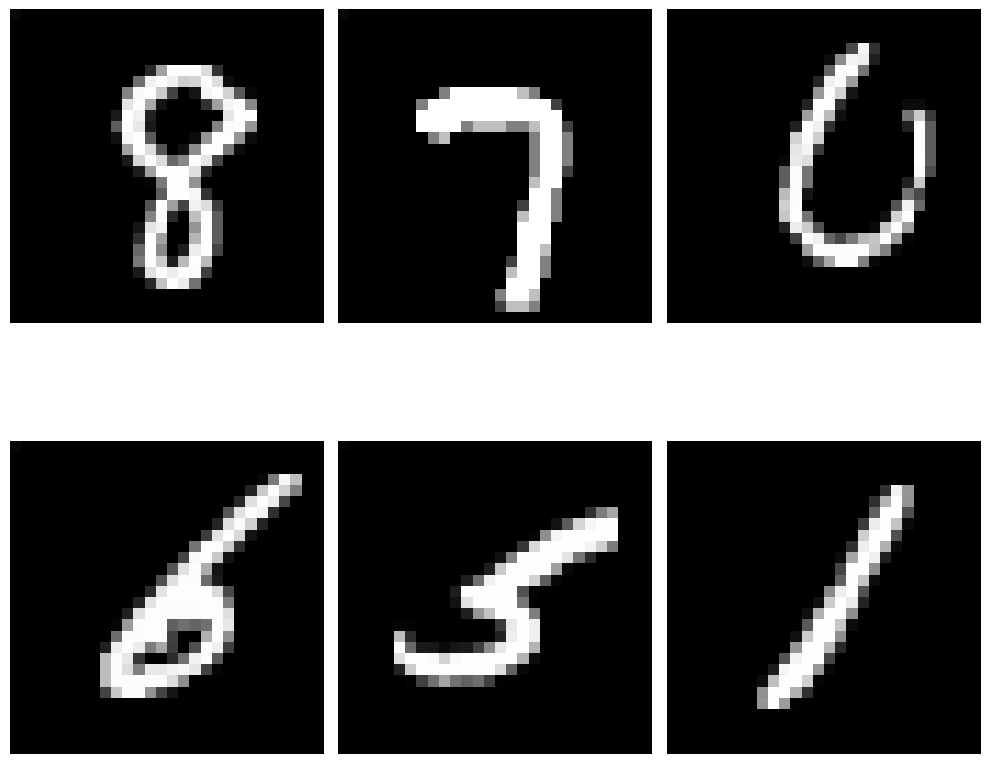

In [71]:
fig, ax = plt.subplots(2,3, figsize=(10,10))
for i in range(2):
    for j in range(3):
        random_index = random.randint(0, df_training_data.shape[0] -1)
        random_image = df_training_data.iloc[random_index, :-1].values.reshape(28, 28)
        ax[i,j].imshow(random_image,  cmap='gray')
        ax[i,j].axis('off')
plt.tight_layout()
plt.show()   

3.0 Check for null values

In [73]:
print(f" Null values in training data: {df_training_data.isnull().sum()}")
print(f" Null values in test data: {df_test_data.isnull().sum()}")

 Null values in training data: label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64
 Null values in test data: pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64


4.0 Data Pre-Processing Pipeline for CNN


4.1 define dependent and independent features

In [126]:
"""
we need to seperate independent and dependent variables
"""
X = df_training_data.drop(columns=['label'])
Y = df_training_data['label']
len(X)

42000

4.2 reshape all images from 784 to 28 by 28

In [139]:
X_train = np.reshape(X,(-1, 28,28, 1))
df_test_data = np.reshape(df_test_data,(-1, 28,28, 1))
print(X_train.shape)
print(df_test_data.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


4.3 Normalize

In [138]:
X_train = X_train.astype('float32') / 255.0
df_test_data = df_test_data.astype('float32') / 255.0
print(df_test_data.shape)

(28000, 28, 28, 1)


4.4 One hot encoding

In [129]:
y_train = to_categorical(Y)
len(y_train)

42000

5.0 Model training with K_fold cross validation

In [151]:
# define function to create the CNN model. in a function we must give the full path e.g. baseline = Sequential is normal now we must do tf.keras.models.Sequential
def create_cnn_model():
    baseline_model = tf.keras.models.Sequential ([
        #block one
        Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.2),
        MaxPooling2D(pool_size=(2,2)),
        
        #block two
        Conv2D(64, (3,3), activation='relu', padding='same'),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.2),
        MaxPooling2D(pool_size=(2,2)),
        
        Flatten(),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
        
    learning_rate = 0.001
    optimizer = Adam(learning_rate=learning_rate)
        
        #complie model
    baseline_model.compile(
        optimizer = optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    baseline_model.summary()
    
    return baseline_model

6.0 Apply K_fold

In [152]:
kf = KFold(n_splits=5, shuffle=True)

In [153]:
fold_no = 1
results = []
accuracy_per_fold = []
cvScores = []

In [154]:
for train_idx, val_idx in kf.split(X_train):
    
    print(f" Fold {fold_no}")
    print(train_idx, val_idx)
    print(f" Training indices: {train_idx.shape}")
    print(f" Validation indices: {val_idx.shape}")
    
    # split the data use _fold to ensure we do not overwrite the origin x_train and y_train during each iteration
    # of KFold
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    print(f" Print x val and check numbers: {X_val_fold.shape}")
    print(f" Print out y_val and check numbers: {y_val_fold.shape}")
    
    # create cnn and train model
    baseline_model = create_cnn_model()
    model_history = baseline_model.fit(
        X_train_fold, y_train_fold, epochs=15, validation_data=(X_val_fold, y_val_fold), verbose=2)
    
    #evaluate the model on validation set
    scores = baseline_model.evaluate(X_val_fold, y_val_fold, verbose=2)
    accuracy_per_fold.append(scores[1] *100)
    print(f'Score for fold {fold_no}: {baseline_model.metrics_names[1]} of {scores[1]*100}%')
    results.append(scores[1] *100)
    fold_no += 1
print(f'Average accuracy across folds: {np.mean(results)}%') 

 Fold 1
[    0     3     5 ... 41997 41998 41999] [    1     2     4 ... 41977 41990 41992]
 Training indices: (33600,)
 Validation indices: (8400,)
 Print x val and check numbers: (8400, 28, 28, 1)
 Print out y_val and check numbers: (8400, 10)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_101 (Conv2D)             │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,946 (1.83 MB)

 Trainable params: 479,754 (1.83 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/15
1050/1050 - 22s - 21ms/step - accuracy: 0.9321 - loss: 0.2236 - val_accuracy: 0.9731 - val_loss: 0.0984
Epoch 2/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9730 - loss: 0.0935 - val_accuracy: 0.9844 - val_loss: 0.0526
Epoch 3/15
1050/1050 - 20s - 19ms/step - accuracy: 0.9809 - loss: 0.0660 - val_accuracy: 0.9854 - val_loss: 0.0502
Epoch 4/15
1050/1050 - 20s - 19ms/step - accuracy: 0.9843 - loss: 0.0549 - val_accuracy: 0.9870 - val_loss: 0.0456
Epoch 5/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9856 - loss: 0.0511 - val_accuracy: 0.9849 - val_loss: 0.0573
Epoch 6/15
1050/1050 - 22s - 21ms/step - accuracy: 0.9863 - loss: 0.0469 - val_accuracy: 0.9921 - val_loss: 0.0310
Epoch 7/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9876 - loss: 0.0400 - val_accuracy: 0.9908 - val_loss: 0.0321
Epoch 8/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9885 - loss: 0.0394 - val_accuracy: 0.9917 - val_loss: 0.0314
Epoch 9/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9909 - loss: 0.0303 - val_a

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_105 (Conv2D)             │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,946 (1.83 MB)

 Trainable params: 479,754 (1.83 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9346 - loss: 0.2177 - val_accuracy: 0.9782 - val_loss: 0.0712
Epoch 2/15
1050/1050 - 20s - 19ms/step - accuracy: 0.9736 - loss: 0.0914 - val_accuracy: 0.9820 - val_loss: 0.0642
Epoch 3/15
1050/1050 - 20s - 19ms/step - accuracy: 0.9793 - loss: 0.0702 - val_accuracy: 0.9742 - val_loss: 0.0972
Epoch 4/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9833 - loss: 0.0565 - val_accuracy: 0.9863 - val_loss: 0.0451
Epoch 5/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9866 - loss: 0.0468 - val_accuracy: 0.9839 - val_loss: 0.0598
Epoch 6/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9874 - loss: 0.0442 - val_accuracy: 0.9857 - val_loss: 0.0482
Epoch 7/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9892 - loss: 0.0370 - val_accuracy: 0.9879 - val_loss: 0.0443
Epoch 8/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9903 - loss: 0.0333 - val_accuracy: 0.9869 - val_loss: 0.0464
Epoch 9/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9913 - loss: 0.0319 - val_a

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_109 (Conv2D)             │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,946 (1.83 MB)

 Trainable params: 479,754 (1.83 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/15
1050/1050 - 25s - 24ms/step - accuracy: 0.9328 - loss: 0.2269 - val_accuracy: 0.9771 - val_loss: 0.0749
Epoch 2/15
1050/1050 - 32s - 30ms/step - accuracy: 0.9741 - loss: 0.0923 - val_accuracy: 0.9840 - val_loss: 0.0535
Epoch 3/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9800 - loss: 0.0720 - val_accuracy: 0.9870 - val_loss: 0.0445
Epoch 4/15
1050/1050 - 501s - 478ms/step - accuracy: 0.9821 - loss: 0.0646 - val_accuracy: 0.9685 - val_loss: 0.1393
Epoch 5/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9849 - loss: 0.0525 - val_accuracy: 0.9860 - val_loss: 0.0496
Epoch 6/15
1050/1050 - 577s - 549ms/step - accuracy: 0.9873 - loss: 0.0434 - val_accuracy: 0.9876 - val_loss: 0.0456
Epoch 7/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9877 - loss: 0.0429 - val_accuracy: 0.9870 - val_loss: 0.0441
Epoch 8/15
1050/1050 - 558s - 532ms/step - accuracy: 0.9903 - loss: 0.0352 - val_accuracy: 0.9880 - val_loss: 0.0383
Epoch 9/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9901 - loss: 0.0346 -

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_113 (Conv2D)             │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,946 (1.83 MB)

 Trainable params: 479,754 (1.83 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/15
1050/1050 - 22s - 21ms/step - accuracy: 0.9338 - loss: 0.2156 - val_accuracy: 0.9802 - val_loss: 0.0643
Epoch 2/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9740 - loss: 0.0924 - val_accuracy: 0.9842 - val_loss: 0.0522
Epoch 3/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9808 - loss: 0.0689 - val_accuracy: 0.9850 - val_loss: 0.0500
Epoch 4/15
1050/1050 - 27s - 26ms/step - accuracy: 0.9845 - loss: 0.0539 - val_accuracy: 0.9694 - val_loss: 0.1012
Epoch 5/15
1050/1050 - 27s - 26ms/step - accuracy: 0.9847 - loss: 0.0541 - val_accuracy: 0.9865 - val_loss: 0.0499
Epoch 6/15
1050/1050 - 491s - 468ms/step - accuracy: 0.9876 - loss: 0.0411 - val_accuracy: 0.9844 - val_loss: 0.0615
Epoch 7/15
1050/1050 - 22s - 21ms/step - accuracy: 0.9882 - loss: 0.0407 - val_accuracy: 0.9910 - val_loss: 0.0365
Epoch 8/15
1050/1050 - 22s - 21ms/step - accuracy: 0.9904 - loss: 0.0357 - val_accuracy: 0.9876 - val_loss: 0.0468
Epoch 9/15
1050/1050 - 23s - 22ms/step - accuracy: 0.9910 - loss: 0.0311 - val

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_117 (Conv2D)             │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,946 (1.83 MB)

 Trainable params: 479,754 (1.83 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/15
1050/1050 - 30s - 28ms/step - accuracy: 0.9334 - loss: 0.2143 - val_accuracy: 0.9686 - val_loss: 0.1086
Epoch 2/15
1050/1050 - 28s - 27ms/step - accuracy: 0.9725 - loss: 0.0965 - val_accuracy: 0.9830 - val_loss: 0.0599
Epoch 3/15
1050/1050 - 27s - 26ms/step - accuracy: 0.9795 - loss: 0.0705 - val_accuracy: 0.9821 - val_loss: 0.0584
Epoch 4/15
1050/1050 - 25s - 24ms/step - accuracy: 0.9837 - loss: 0.0571 - val_accuracy: 0.9867 - val_loss: 0.0541
Epoch 5/15
1050/1050 - 24s - 23ms/step - accuracy: 0.9857 - loss: 0.0518 - val_accuracy: 0.9849 - val_loss: 0.0580
Epoch 6/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9865 - loss: 0.0446 - val_accuracy: 0.9875 - val_loss: 0.0461
Epoch 7/15
1050/1050 - 21s - 20ms/step - accuracy: 0.9889 - loss: 0.0377 - val_accuracy: 0.9843 - val_loss: 0.0584
Epoch 8/15
1050/1050 - 22s - 21ms/step - accuracy: 0.9889 - loss: 0.0380 - val_accuracy: 0.9877 - val_loss: 0.0482
Epoch 9/15
1050/1050 - 23s - 22ms/step - accuracy: 0.9903 - loss: 0.0320 - val_a

In [155]:
accuracy_per_fold

[99.15476441383362,
 99.04761910438538,
 99.15476441383362,
 99.1428554058075,
 98.94047379493713]

In [156]:
avgScores = np.mean(accuracy_per_fold)
stdScores = np.std(accuracy_per_fold)

print(f'Average accuracy across folds: {avgScores*100}%')
print(f'Standard Deviation across folds: {stdScores*100}%')

Average accuracy across folds: 9908.809542655945%
Standard Deviation across folds: 8.404598959515795%


7.0 Model Evaluation

In [157]:
prediction = baseline_model.predict(df_test_data)

875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


In [158]:
print(prediction.shape)

(28000, 10)


In [160]:
result = np.argmax(prediction, axis=1)
result = pd.Series(result, name ="Label")
print(result)

0        1
1        1
2        1
3        1
4        1
        ..
27995    1
27996    1
27997    1
27998    1
27999    1
Name: Label, Length: 28000, dtype: int64


In [161]:
# check balance or distribution of classes class o 4132, class 1 4684 class 2 4177 etc to class 9 all well balanced with 4000 odd samples
print(np.bincount(np.argmax(y_train, axis=1)))

[4132 4684 4177 4351 4072 3795 4137 4401 4063 4188]


8.0 Submission

In [137]:
submission = pd.concat([pd.Series(range(1,28001), name= "ImageId"), result], axis=1)
submission.to_csv('/Users/godfreykrutzsch/Desktop/digit-recognizer/submission_cross_validationA.csv', index=False)
